In [1]:
from pathlib import Path

import seaborn as sns

import analysis
import load_save

sns.set_theme(style="whitegrid")

In [2]:
output_dir = Path("data")
cases = ["asap", "throttled"]

In [3]:
base_distribution = load_save.load_base_distribution(output_dir)
campaigns = load_save.load_campaigns(output_dir)
events = load_save.load_events_from_multiple_cases(output_dir, cases, ["win", "no win"])

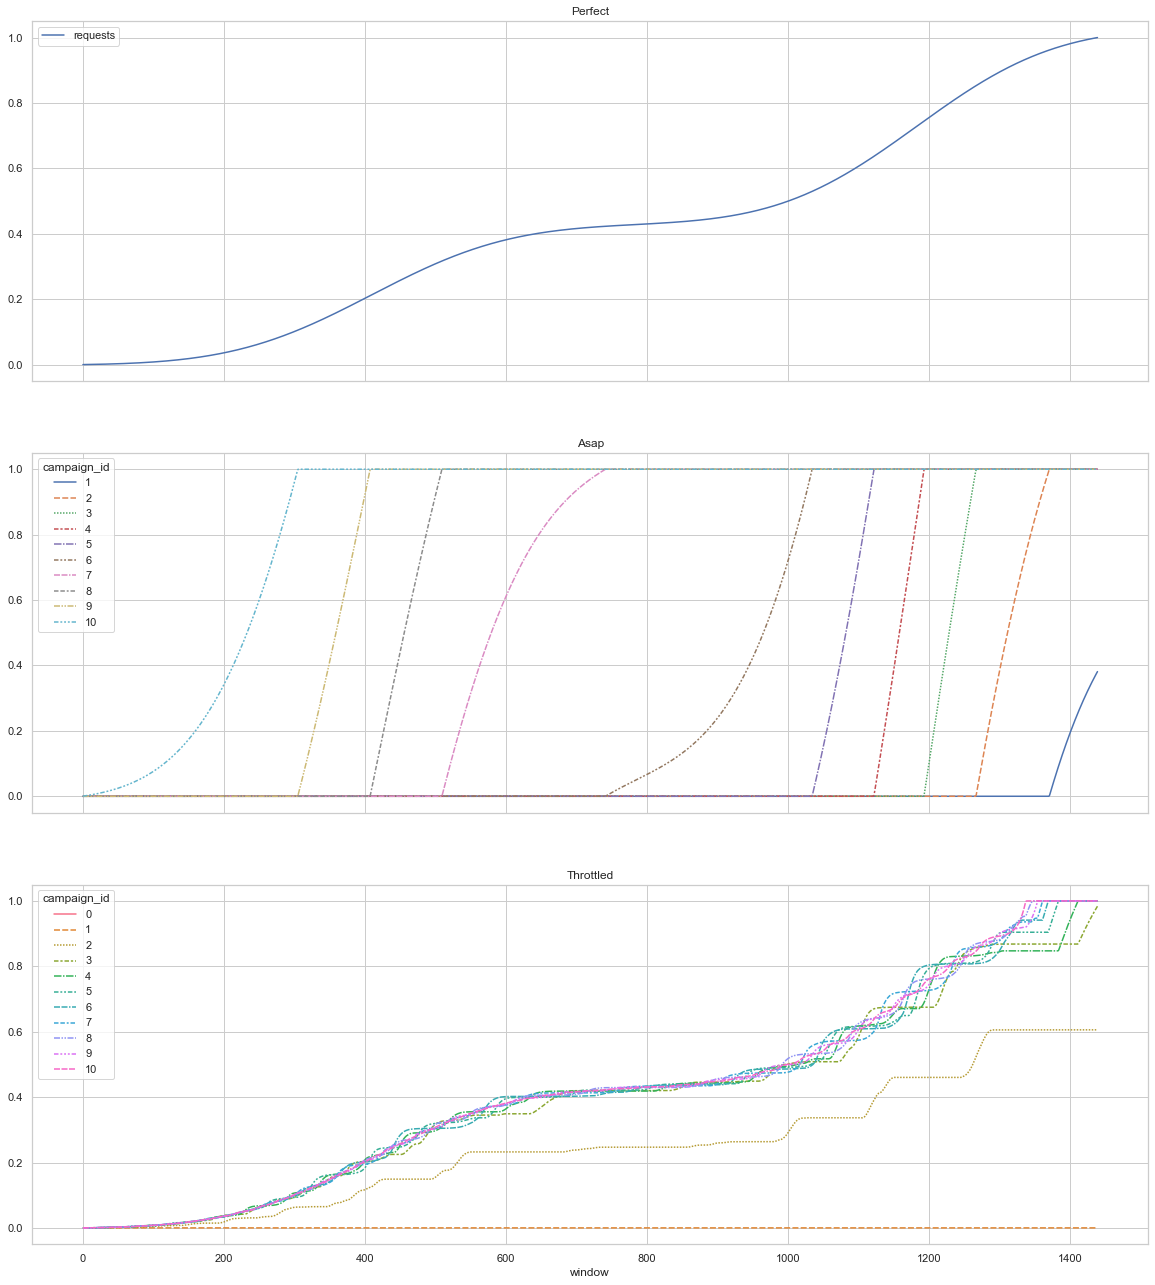

In [4]:
analysis.compare_budget_spending(campaigns, base_distribution, events)

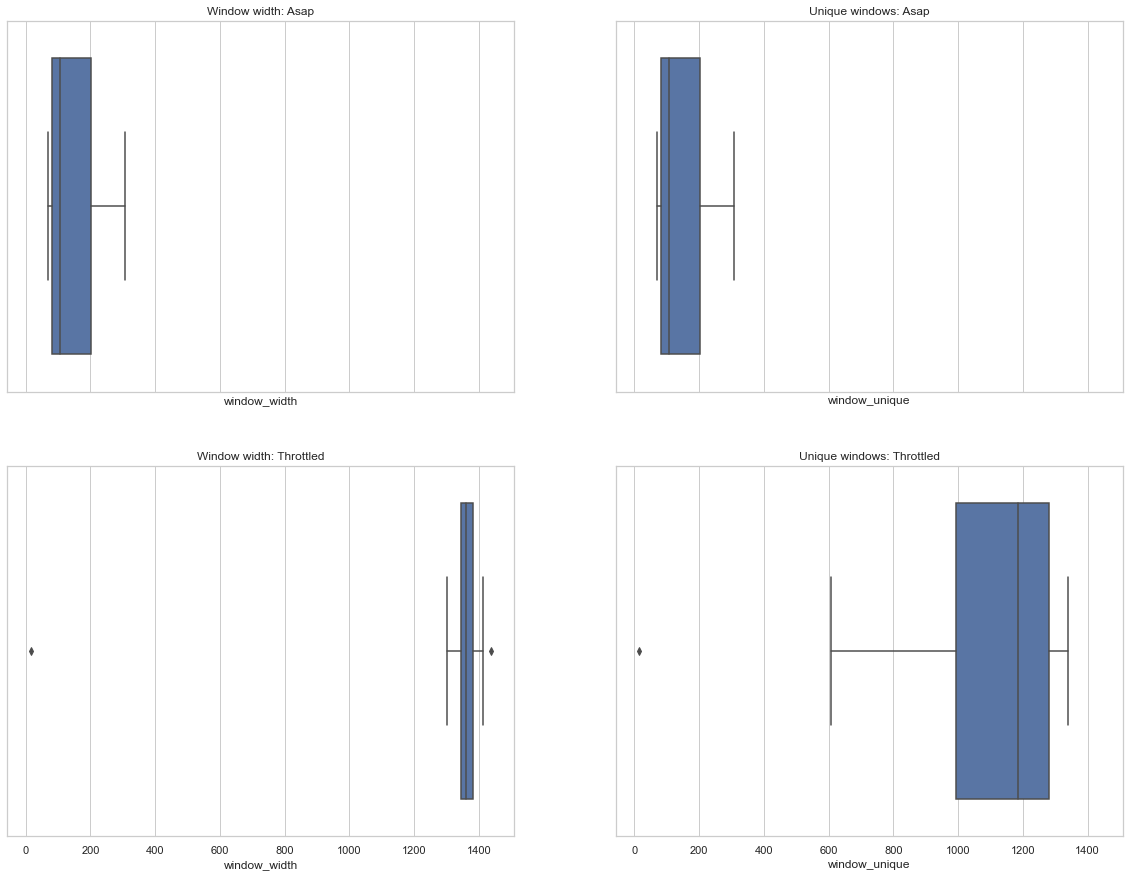

In [5]:
analysis.compare_lifespan(events)

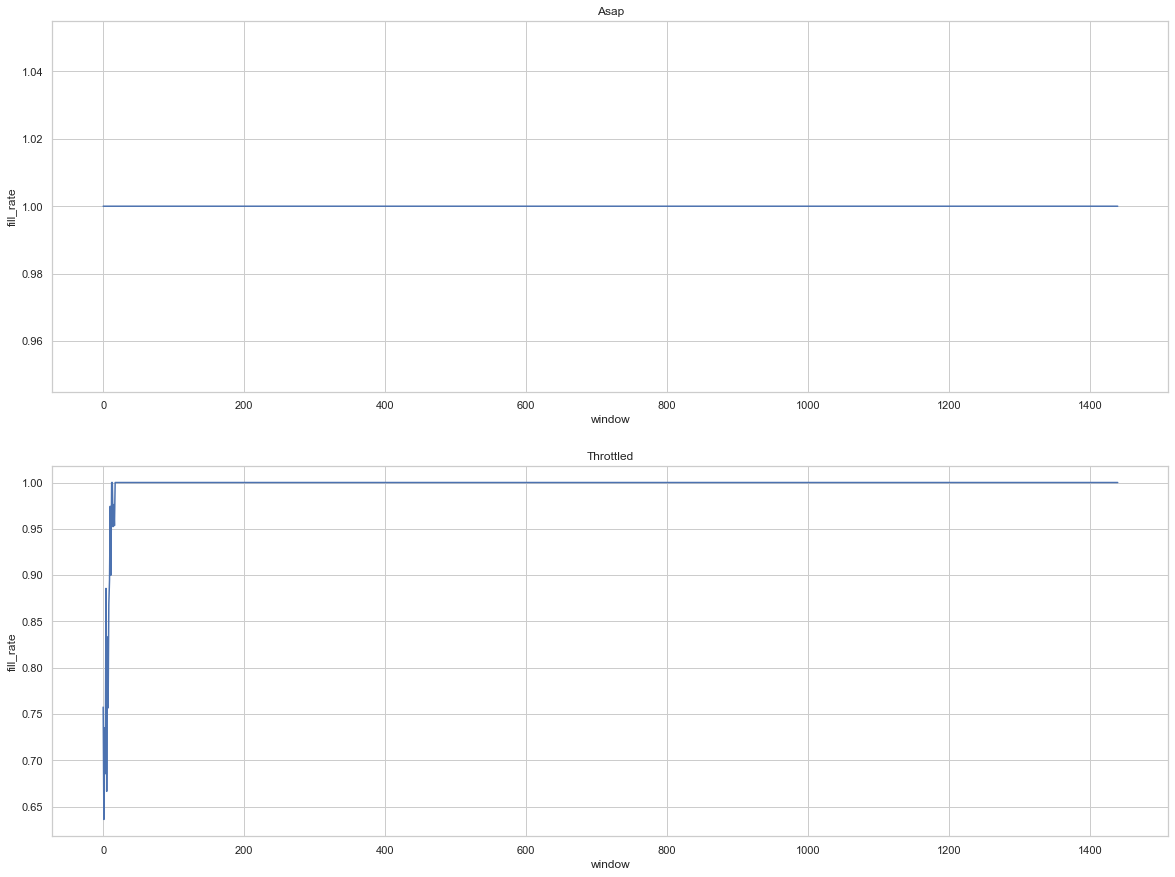

In [6]:
analysis.compare_fill_rate(events)

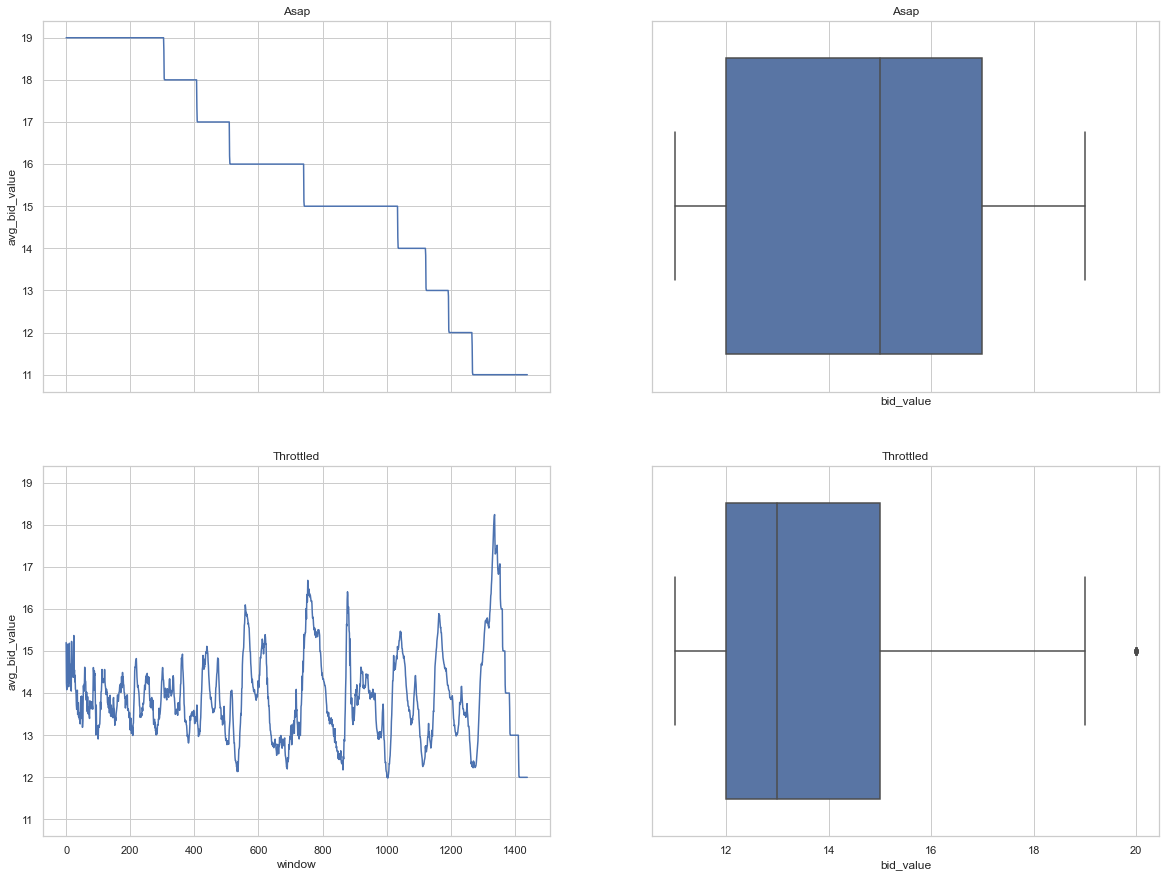

In [7]:
analysis.compare_bid_value(events)

In [8]:
analysis.summary_comparison(events)

,window_width,unique_windows,fill_rate,revenue
asap,0.209107,0.224794,1.00000,1.000000
throttled,1.000000,1.000000,0.99991,0.938384
